# ML勉強会03 ~ mnistの手書き文字認識を使って、ディープラーニングを理解してみる
## データセット
- MNISTの手書き文字 http://yann.lecun.com/exdb/mnist/

## 参考
- [ゼロから作る DeepLearning](https://www.oreilly.co.jp/books/9784873117584/)

## ニューラルネットワークの仕組み
今回は参考の本に習って、MNISTの手書き文字を2層で処理するものを考える。

その場合概ね、以下のような構造となる

![image.png](img/01.png)

たくさんの変数が出てくるが、ざっくりいうと、各入力値1つ1つに対して重みをかけて、それを何層か繰り返すことでそれが何であるのかを分類していくようなイメージのようだ。

## 学習 = 重みの獲得
重みは学習の中で自動的に獲得される。

ニューラルネットワークは概ね以下のようなイメージとなるが、つまり、出力結果が正解ラベルと近しくなるようなパラメータを選択する必要がある。

![image.png](img/02.png)


以下では具体的な実装例を見ながら上記について考えていく。

## おまじない
とりあえず必要なものをimportする

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
%matplotlib inline

## データセットの読み込み
- mnistでダウンロードしたTraining用のラベル、画像、Test用のラベル、画像を読み込ませる
- なお、ラベルは通常の数値ではなく、1-hot表現で取り込んでいる。
- 1-hot表現は例えば7が正解なら[0,0,0,0,0,0,0,1,0,0]のように正解のところに1が立っていて、それ以外は0となるような表現のことを言う

### Load Labels(Training Data)

In [3]:
file = gzip.open("mnist/train-labels-idx1-ubyte.gz", "rb")
label_data = file.read()
file.close()
magic = int.from_bytes(label_data[0:4], byteorder='big')
num_of_data = int.from_bytes(label_data[4:8], byteorder='big')
print(magic)
print(num_of_data)
t_train  = np.ndarray((num_of_data,10), dtype='uint8')
offset = 8
for i in range(0, num_of_data):
  t_train [i] = np.zeros(10,dtype="int8")
  t_train [i][label_data[offset+i]] = 1

print ("shape: {}".format(t_train.shape))

2049
60000
shape: (60000, 10)


### Load Image(Training Data)

In [4]:
file = gzip.open("mnist/train-images-idx3-ubyte.gz", "rb")
dataset = file.read()
file.close()
magic = int.from_bytes(dataset[0:4], byteorder='big')
num_of_data = int.from_bytes(dataset[4:8], byteorder='big')
num_of_rows = int.from_bytes(dataset[8:12], byteorder='big')
num_of_cols = int.from_bytes(dataset[12:16], byteorder='big')
print(magic)
print(num_of_data)
print(num_of_rows)
print(num_of_cols)
data_size = num_of_rows * num_of_cols
x_train = np.ndarray((num_of_data, data_size), dtype='uint8')
offset = 16
for i in range(0, num_of_data):
    for j in range(0, data_size):
      x_train[i][j] = dataset[offset+i*data_size+j]

print ("shape: {}".format(x_train.shape))

2051
60000
28
28
shape: (60000, 784)


### Load Labels (Test Label)

In [5]:
file = gzip.open("mnist/t10k-labels-idx1-ubyte.gz", "rb")
label_data = file.read()
file.close()
magic = int.from_bytes(label_data[0:4], byteorder='big')
num_of_data = int.from_bytes(label_data[4:8], byteorder='big')
print(magic)
print(num_of_data)
t_test = np.ndarray((num_of_data,10), dtype='int8')
offset = 8
for i in range(0, num_of_data):
  t_test [i] = np.zeros(10,dtype="uint8")
  t_test [i][label_data[offset+i]] = 1

print ("shape: {}".format(t_test.shape))

2049
10000
shape: (10000, 10)


### Load Data(Test Data)

In [6]:
file = gzip.open("mnist/t10k-images-idx3-ubyte.gz", "rb")
dataset = file.read()
file.close()
magic = int.from_bytes(dataset[0:4], byteorder='big')
num_of_data = int.from_bytes(dataset[4:8], byteorder='big')
num_of_rows = int.from_bytes(dataset[8:12], byteorder='big')
num_of_cols = int.from_bytes(dataset[12:16], byteorder='big')
print(magic)
print(num_of_data)
print(num_of_rows)
print(num_of_cols)
data_size = num_of_rows * num_of_cols
x_test = np.ndarray((num_of_data, data_size), dtype='uint8')
offset = 16
for i in range(0, num_of_data):
    for j in range(0, data_size):
      x_test[i][j] = dataset[offset+i*data_size+j]

print ("shape: {}".format(x_test.shape))

2051
10000
28
28
shape: (10000, 784)


### 1つ表示してみる
- なんとなく読み込めていることを確認するために、適当なところを1つ表示してみます。

label : [0 0 0 0 0 0 0 1 0 0]


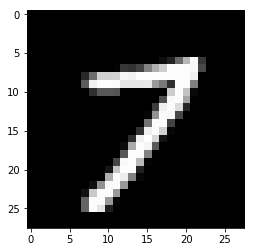

In [7]:
num_of_showimg = 9885
print("label : {}".format(t_train[num_of_showimg]))
img = Image.fromarray(np.uint8(x_train[num_of_showimg].reshape(28,28)))
plt.imshow(img)

## 出力値の確立値化 : softmax関数
- softmax関数は出力層で利用され、その出力値の合計は1になります。

In [8]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

x = np.arange(-5.0, 5.0, 0.1)
y = softmax(x)
print("sum of softmax: {}".format(np.sum(y)))

sum of softmax: 1.0


## 活性化関数: シグモイド

- シグモイド関数は以下に通りある値を境にゆるやかに出力を変化させる非線形関数である。
- 最初の図のh(x)として利用され、ある一定の値を超えたら値を出力するように、とある特徴量がある閾値を超えたら大きな値が出力されるようになる。

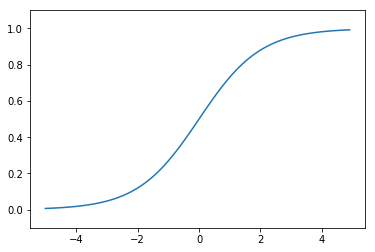

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x,y)
plt.ylim(-0.1,1.1)
plt.show()

## 重みの獲得
### 結果の"悪さ"を数値化: 損失関数
- 上の絵で書いた出力値と正解ラベルの評価では損失関数を用いる。
- 損失関数は色々な種類がありえるが、ここでは交差エントロピー関数を用いる。
- 損失関数に交差エントロピー関数を用いると、その値は-t(正解ラベル) * log(y(出力値))となる。
- 正解ラベルはone hot表現で表されているため、正解ラベル以外はゼロでなくなるため、実質-log(y(正解ラベルの出力値))となる。
- これはつまり、出力値が1.0に近づく（つまり正しい状態）になると出力はゼロに近づき、逆に0に近づく（不正確）となると、出力値は大きくなる。
- この場合、交差エントロピー関数が最小となるような重みを探していくことになる。

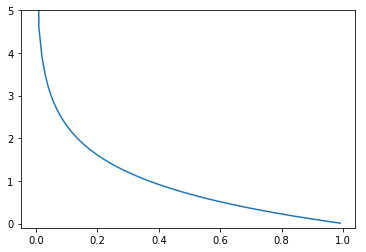

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot表現の場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

x = np.arange(0.0, 1.0, 0.01)
y = -np.log(x+ 1e-7)
plt.plot(x,y)
plt.ylim(-0.1,5.0)
plt.show()

### パラメータの修正料を決定: 勾配の計算
- 勾配はある地点の傾斜を表す。
- つまり、交差エントロピー関数のある地点の勾配を計算することで、より交差エントロピー関数の出力が小さい = 正解に近い出力を探索できます。
- ただし、ここで計算した結果をそのままフィードバックするわけではなく、後ろに記載の学習率をかけてフィードバックする。

In [11]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = float(tmp_val) - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        #print("01 -> fxh1 = {}".format(fxh1))
        #print("01 -> fxh2 = {}".format(fxh2))

        x[idx] = tmp_val # 値を元に戻す
        
        it.iternext()

    return grad

## 全体の流れをコード化する
### 重み
- 初期段階では乱数で決定する。

In [12]:
input_size=784
hidden_size=50
output_size=10
weight_init_std=0.01

class Params:
    def __init__(self):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

p = Params()

### ハイパーパラメータ
- 学習などのキーとなるハイパーパラメータを設定する
- これは手動で設定する必要があり、難しいところらしい。
- 例えば学習の繰り返し回数や、バッチサイズ、学習率等が挙げられる

In [17]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

### 2層のニューラルネットワークを定義
- ここで実態の計算であるニューラルネットワークを定義している。

In [14]:
def predict(x):
    W1, W2 = p.params['W1'], p.params['W2']
    b1, b2 = p.params['b1'], p.params['b2']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)
        
    return y

### 誤差伝播法
- ここまで書いておいてなんだが、上記の方法はとてつもなく遅いので高速な方法をここで書く。
- まだ理解しきれていないので、理解できたら解説書く。

In [15]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def gradient(x, t):
    W1, W2 = p.params['W1'], p.params['W2']
    b1, b2 = p.params['b1'], p.params['b2']
    grads = {}

    batch_num = x.shape[0]

    # forward
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    # backward
    dy = (y - t) / batch_num
    grads['W2'] = np.dot(z1.T, dy)
    grads['b2'] = np.sum(dy, axis=0)

    dz1 = np.dot(dy, W2.T)
    da1 = sigmoid_grad(a1) * dz1
    grads['W1'] = np.dot(x.T, da1)
    grads['b1'] = np.sum(da1, axis=0)

    return grads

train acc, test acc | 0.0993166666667, 0.1011


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train acc, test acc | 0.841733333333, 0.8447
train acc, test acc | 0.8572, 0.862
train acc, test acc | 0.852116666667, 0.8581
train acc, test acc | 0.858933333333, 0.8675
train acc, test acc | 0.8626, 0.8697
train acc, test acc | 0.846266666667, 0.8509
train acc, test acc | 0.868933333333, 0.877
train acc, test acc | 0.86625, 0.8715
train acc, test acc | 0.860783333333, 0.8676
train acc, test acc | 0.865633333333, 0.8728
train acc, test acc | 0.8688, 0.8691
train acc, test acc | 0.877033333333, 0.8784
train acc, test acc | 0.870083333333, 0.8727
train acc, test acc | 0.879383333333, 0.8793
train acc, test acc | 0.880816666667, 0.8787
train acc, test acc | 0.887933333333, 0.8873


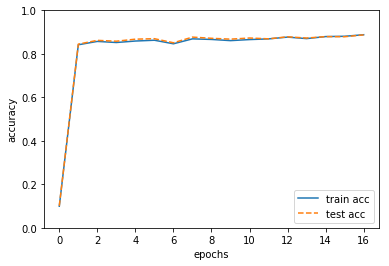

In [16]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = int(max(train_size / batch_size, 1))

for i in range(iters_num):

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    loss_W = lambda W: loss(x_batch, t_batch)
    
    grads = {}
    #grads['W1'] = numerical_gradient(loss_W, p.params['W1'])
    #grads['b1'] = numerical_gradient(loss_W, p.params['b1'])
    #grads['W2'] = numerical_gradient(loss_W, p.params['W2'])
    #grads['b2'] = numerical_gradient(loss_W, p.params['b2'])
    
    
    grads = gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        p.params[key] -= learning_rate * grads[key]

    y = predict(x_batch)
    loss_val = cross_entropy_error(y, t_batch)
    train_loss_list.append(loss_val)
    
    if i % iter_per_epoch == 0:
        
        y = predict(x_train)
        y = np.argmax(y, axis=1)
        t = np.argmax(t_train, axis=1)
        train_acc = np.sum(y == t) / float(x_train.shape[0])
        
        y = predict(x_test)
        y = np.argmax(y, axis=1)
        t = np.argmax(t_test, axis=1)
        test_acc = np.sum(y == t) / float(x_test.shape[0])
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
